# Provenance Tracker Demo with UCI Census Income KDD Dataset

This notebook demonstrates the capabilities of the `provenance_tracker` project using the UCI Census Income KDD dataset (ID 117). We will show how to track data cleaning and completion operations using the `ProvenanceTracker` and `ProvenanceDataFrame` classes.

We will cover
1. Setup and Data Loading
2. Injecting Noise (Simulation)
3. Cleaning Operations
4. Completion Operations
5. Inspecting Provenance Data

In [1]:
# Install ucimlrepo if not already installed
!pip install ucimlrepo graphviz

In [2]:
import sys
import os

# Add parent directory to path to import the module
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from Provenance_final import ProvenanceTracker, ProvenanceDataFrame

## 1. Setup and Data Loading

We load the Census Income KDD dataset using `ucimlrepo`.

In [3]:
print("Loading the Dataset Now")
census_income_kdd = fetch_ucirepo(id=117)

# extract the features and targets
X = census_income_kdd.data.features
y = census_income_kdd.data.targets

# Combine features and targets into one matrix
df_raw = pd.concat([X, y], axis=1)

# Take a smaller sample for the demo--->70%
df_raw = df_raw.sample(n=int(df_raw.shape[0]/(100/70)), random_state=42).reset_index(drop=True)

print(f"Loaded dataset sample with shape: {df_raw.shape}")
print(df_raw.head())

Loading the Dataset Now
Loaded dataset sample with shape: (139666, 42)
   AAGE              ACLSWKR  ADTINK  ADTOCC  \
0    47     Local government      43      26   
1    39              Private      25      26   
2    56              Private      41       8   
3    39   Federal government      50       6   
4    11      Not in universe       0       0   

                                   AHGA            AHSCOL  \
0                  High school graduate   Not in universe   
1                  High school graduate   Not in universe   
2   Associates degree-occup /vocational   Not in universe   
3            Bachelors degree(BA AB BS)   Not in universe   
4                              Children   Not in universe   

                            AMARITL                           AMJIND  \
0   Married-civilian spouse present                        Education   
1                          Divorced   Manufacturing-nondurable goods   
2   Married-civilian spouse present                Hospit

## 2. Injecting Noise (Simulation)

We'll artificially introduce some missing values and inconsistencies to demonstrate the tracker's cleaning capabilities.

In [4]:
np.random.seed(42)

# make masks for selecting and imputing calculations

# Inject NaNs in 'AAGE' (Age)
mask_age = np.random.choice([True, False], size=len(df_raw), p=[0.05, 0.95])
df_raw.loc[mask_age, 'AAGE'] = np.nan

# Inject '?' in 'ACLSWKR' (Class of worker)
mask_work = np.random.choice([True, False], size=len(df_raw), p=[0.05, 0.95])
df_raw.loc[mask_work, 'ACLSWKR'] = '?'

print("Added noise/artificial values into the dataset")

Added noise/artificial values into the dataset


Now we initialize the `ProvenanceTracker`.

In [5]:
tracker = ProvenanceTracker(dataset_name="census_income_kdd", agent="user_test")
prov_df = ProvenanceDataFrame(df_raw, tracker)

## 3. Cleaning Operations

**Step 1: Replace placeholders**

In [6]:
prov_df = prov_df.replace(['?'], np.nan)
print("Replaced '?' with NaN")

Replaced '?' with NaN


**Step 2: Handle Missing Values**

Fill missing `AAGE` with median and `ACLSWKR` with 'Unknown'.

In [7]:
#impute the median and replace missing values with that.
median_age = prov_df.df['AAGE'].median()
prov_df = prov_df.fillna({'AAGE': median_age})
prov_df = prov_df.fillna({'ACLSWKR': 'Unknown'})

## 4. Completion Operations

Let's enrich the data. We'll create a mapping for `ASEX` to a full description.

In [8]:
# creating a new set of features from ASEX
sex_desc = pd.DataFrame({
    'ASEX': ['Male', 'Female'],
    'sex_desc': ['Male Gender', 'Female Gender']
})

prov_df = prov_df.merge(sex_desc, on='ASEX', how='left')
print("Merged with sex descriptions")
print(prov_df.df[['ASEX', 'sex_desc']].head())

Merged with sex descriptions
      ASEX sex_desc
0   Female      NaN
1     Male      NaN
2   Female      NaN
3   Female      NaN
4   Female      NaN


## 5. Inspecting Provenance Data

Let's look at the recorded history.

In [9]:
print(f"Total operations recorded: {len(tracker.records)}")

for i, record in enumerate(tracker.records):
    print(f"\n--- Operation {i+1}: {record.op_name} ---")
    print(f"Timestamp: {record.timestamp}")
    print(f"Parameters: {record.parameters}")
    print(f"Shape Change: {record.pre_shape} -> {record.post_shape}")
    print(f"Deltas: {record.deltas}")
    print(f"Data Quality: {record.data_quality}")

Total operations recorded: 4

--- Operation 1: replace ---
Timestamp: 2025-12-08T01:26:12Z
Parameters: {'args': [['?'], nan], 'kwargs': {}}
Shape Change: (139666, 42) -> (139666, 42)
Deltas: {'row_count_change': 0, 'column_added': [], 'column_removed': [], 'changed_cells_on_common': 305090, 'delta_percentage': np.float64(5.201013574561896)}
Data Quality: {'pre_missing': {'na_by_col': {'AAGE': 6921, 'ACLSWKR': 0, 'ADTINK': 0, 'ADTOCC': 0, 'AHGA': 0, 'AHSCOL': 0, 'AMARITL': 0, 'AMJIND': 0, 'AMJOCC': 0, 'ARACE': 0, 'AREORGN': 0, 'ASEX': 0, 'AUNMEM': 0, 'AUNTYPE': 0, 'AWKSTAT': 0, 'CAPGAIN': 0, 'GAPLOSS': 0, 'DIVVAL': 0, 'FILESTAT': 0, 'GRINREG': 0, 'GRINST': 488, 'HHDFMX': 0, 'HHDREL': 0, 'MARSUPWRT': 0, 'MIGMTR1': 69837, 'MIGMTR3': 69837, 'MIGMTR4': 69837, 'MIGSAME': 0, 'MIGSUN': 69837, 'NOEMP': 0, 'PARENT': 0, 'PEFNTVTY': 4742, 'PEMNTVTY': 4358, 'PENATVTY': 2428, 'PRCITSHP': 0, 'SEOTR': 0, 'VETQVA': 0, 'VETYN': 0, 'WKSWORK': 0, 'AHRSPAY': 0, 'year': 0, 'income': 0}, 'question_mark_like_

Graph saved to 'provenance_census_graph.dot'


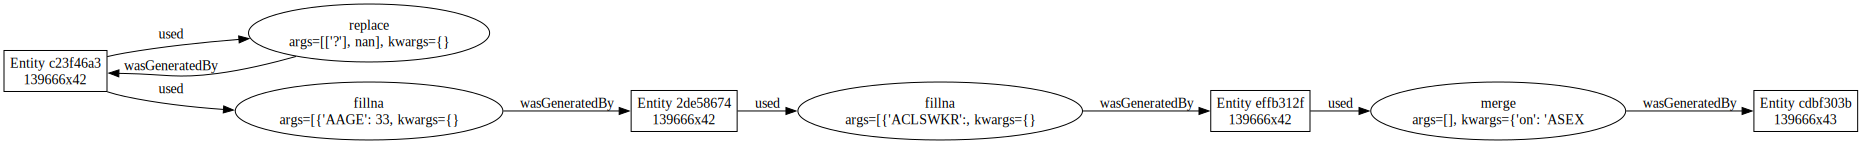

In [10]:
tracker.save_graph("provenance_census_graph.dot")
tracker.save_json("provenance_census_log.json")

print("Graph saved to 'provenance_census_graph.dot'")

try:
    import graphviz
    with open("provenance_census_graph.dot", "r") as f:
        dot_graph = f.read()
    display(graphviz.Source(dot_graph))
except ImportError:
    print("Graphviz library not found. Use an online DOT viewer to see 'provenance_census_graph.dot'")

In [11]:
try:
    tracker.save_rdf("provenance.ttl")
except ImportError:
    print("rdflib not installed; skipping RDF export.")